# **Capstone Project: Natural Language Processing with Disaster Tweets**


##Corbin McKay



In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


###**About the dataset:**

- This dataset contains over 7,000 tweets (posts) that were hand classified (binary classification for disaster or not disaster)
- Objective: Using natural language processing, predict whether a tweet is announcing a disaster.
- The value 0 in the target label represents non disaster tweets, and the value 1 represents disaster tweets
- Reasoning: Smart phones and social media have enabled people to announce an emergency they are observing in real-time. Being able to classify posts announcing emergencies can be of interest for News Agencies and Disaster Relief Organizations.


Natural Language Processing(NLP) is a field of machine learning that aims to give machines the ability to interpret human language.

Sentiment Analysis is an approach to NLP that identifies the emotional tone behind a sequence of texts.

Since this dataset uses sequential data I will use RNNs

The dataset contains long sequences, so LSTM and GRU cells will be needed to tackle short-term memory issues.

###**Loading the Dataset:**


In [ ]:
from google.colab import files
uploaded = files.upload()

# dataset link - https://www.kaggle.com/competitions/nlp-getting-started/overview
data = pd.read_csv('train.csv')

Saving train.csv to train.csv


In [ ]:
# Displaying the first five entries in dataset
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# display number of rows and columns
data.shape

(7613, 5)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
# get counts for disaster classification
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<Axes: xlabel='target', ylabel='count'>

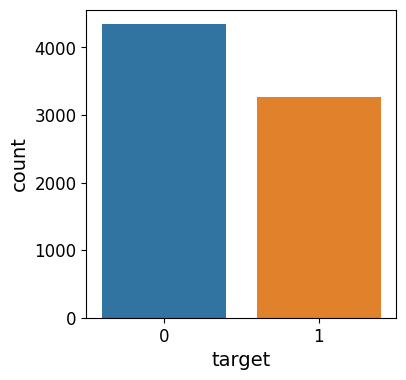

In [ ]:
# Visualizing the binary classification label distribution
plt.figure(figsize = (4,4))
sb.countplot(x='target', data=data)

Lets look at examples of tweets that are disaster and non disaster tweets.

In [ ]:
data[data["target"] == 0]["text"].values[1]

'I love fruits'

In [ ]:
data[data["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

###**Preprocessing the Dataset:**

Many tweets contain links that will not be helpful to the model so they must be cleaned from the dataset.

In [ ]:
import re
def remove_url(text):
  url = re.compile(r"https?://\S+|www\.\S+")
  return url.sub(r"", text)

contains_url = "I sure hope this link disappears https://www.google.com/ "
print(remove_url(contains_url))

I sure hope this link disappears  


In [ ]:
data["text"] = data["text"].map(remove_url)

**Removing Stopwords**

- The stopwords are a list of words that are very common but don't provide useful information for most sentiment analysis.

- Examples of stopwords are: I, a, the, to, and, that, for, was, etc.

- Words such as these will not be useful for detecting disasters

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# set stopwords to english stopwords
stopwords = set(stopwords.words('english'))

# list of all the removed stopwords in nltk's english list
# https://gist.github.com/sebleier/554280

# Remove all stopwords
def remove_stopwords(text):
    text = ' '.join([word.lower() for word in text.split() if word.lower() not in (stopwords)])
    return text

# Initially the word "I" remained in the text due not being lowercase, after some research I found adding lower() in the function solves this issue
stop_test = " Please I am the to in is for how work "
print(remove_stopwords(stop_test))

please work


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data["text"] = data["text"].map(remove_stopwords)

In [ ]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason #earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,residents asked 'shelter place' notified offic...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,got sent photo ruby #alaska smoke #wildfires p...,1


From the example texts from above, the text still contains hashtags, numbers, and words within single quotations. These can all negatively impact the models, so I will apply more cleaning to the data. For example we do not want #danger, danger, @danger, and 'danger' to all be separate word tokens.

In [ ]:
# function to remove punctuation
# source to find function: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/#h-step-5-data-preprocessing
import string
def clean_punct(text):
  translator = str.maketrans('','', string.punctuation)
  return text.translate(translator)

punct_test = " #remove ! @punct. 'test' "
print(clean_punct(punct_test))

 remove  punct test 


I considered removing any word that starts with @. In twitter the @ symbol is used in front of a user. The names of users will most likely will hinder the quality of the dataset. However, I decided not to because of the possibility of tweets using the @ to tag certain news sources or accounts specifically for disasters.

In [ ]:
data["text"] = data["text"].map(clean_punct)

In [ ]:
# confirm the punctuations have been removed
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


- Upon looking at the text above, I questioned whether numbers would contain any sentiment. Numbers are commonly used for measurements for disasters such as magnitude of an earthquake, the sizes of tornados and earthquakes, the number of people effected, county numbers, and so on. The main issue is numbers are so commonly used in any text that it will not be a good sentiment indicator, and the bag of words will be flooded with numbers as tokens.

- I then also considered the removal of emojis. Happy emojis can be a good indication of a non disaster. An emoji such as fire may be commonly used for both disaster and non disaster tweets. Emojies are represented by unicode values. By making the decision to remove numbers, the majority of emojis will be truncated to just UF, making them non distinguishable and of no value.

- By making the decision to remove numbers, I must also remove emojis. It may be worth exploring how models perform with numbers and emojis, so I will make a copy of the data before the removal of numbers and emojis.

In [ ]:
# making a copy of the dataframe before cleaning of numbers and emojis.
twitter_emoj_num = data.copy()

In [ ]:
# function to remove numbers, the same as remove punctuation function but use the digits method in the string class
def clean_num(text):
  translator = str.maketrans('','', string.digits)
  return text.translate(translator)

# verify the function works
num_test = " 1n2o4 47num329be3rs8"
print(clean_num(num_test))

 no numbers


In [ ]:
# remove numbers from dataset
data["text"] = data["text"].map(clean_num)
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders ca...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [ ]:
# I was able to find helpful resources to learn how to insert emojis in text and a function to remove
# https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
# https://www.makeuseof.com/how-to-include-emojis-in-your-python-code/

# funtion to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# test to make sure function works correctly
emoji_test = "Remove emojis \U0001F600 "
print(emoji_test)
print(remove_emoji(emoji_test))

# remove emojis from dataframe
data["text"] = data["text"].map(remove_emoji)

Remove emojis 😀 
Remove emojis  


In [ ]:
twitter_df = data.copy()

In [ ]:
# split and shuffle the datase
X_train, X_test, y_train, y_test = train_test_split(twitter_df['text'], twitter_df['target'], random_state=42)

# Display shape of dataset splits
print("Dataset Split Shapes")
print("-----------------")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Dataset Split Shapes
-----------------
X_train shape: (5709,)
y_train shape: (5709,)
X_test shape: (1904,)
y_test shape: (1904,)


**Using Keras Tokenizer**

A tokenizer is used to convert the string inputs into integers. Each unique word will be represented by an integer. First we tokenize each sequence of text, then pad or truncate the sequences to keep the input sequences the same size.

In [ ]:
# Resources
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=75, truncating='post')  # remove values from sequences larger than maxlen at end of sequence
X_test_padded = pad_sequences(X_test_sequences, maxlen=75, truncating='post')

In [ ]:
print(X_test[0])
print(X_test_sequences[0])

deeds reason earthquake may allah forgive us
[7, 207, 153, 1, 343]


Before begining my models, I designed some metric functions for binary classification to better understand the models performance.

In [ ]:
from keras import backend as K
from keras.utils import metrics_utils


# function to show confusion matrix and print all of the useful metric data from the confusion matrix
def showConfusionMatrix(model, X_test, y_test):
    # evaluating model performance on test dataset
  y_pred = model.predict(X_test) > 0.5
  cm = confusion_matrix(y_test, y_pred)
  labels = ['Non-Disaster', 'Disaster']
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  # use these variables to perform the needed math
  accuracy = ((tp + tn) / (tn + fp + fn + tp)) * 100
  precision = (tp / (tp + fp)) * 100
  misClass = 100 - accuracy
  tpRate = (tp / (tp + fn)) * 100
  tnRate = (tn / (tn + fp)) * 100
  fpRate = (fp / (fp + tn)) * 100
  fnRate = (fn / (fn + tp)) * 100

    # print the results
  print("Binary Classifcation Metrics")
  print("----------------------------")
  print(f"Accuracy: {accuracy:.2f}%")
  print(f"Precision: {precision:.2f}%")
  print(f"Misclassification Rate: {misClass:.2f}%")
  print(f"True Positive Rate(Disaster Tweet Label Accuracy): {tpRate:.2f}%")
  print(f"True Negative Rate(Non-Disaster Tweet Label Accuracy): {tnRate:.2f}%")
  print(f"False Positive Rate: {fpRate:.2f}%")
  print(f"False Negative Rate: {fnRate:.2f}%")


  sb.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')

# learning curve plot function from book
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

###**Model 1: Simple LSTM Model**


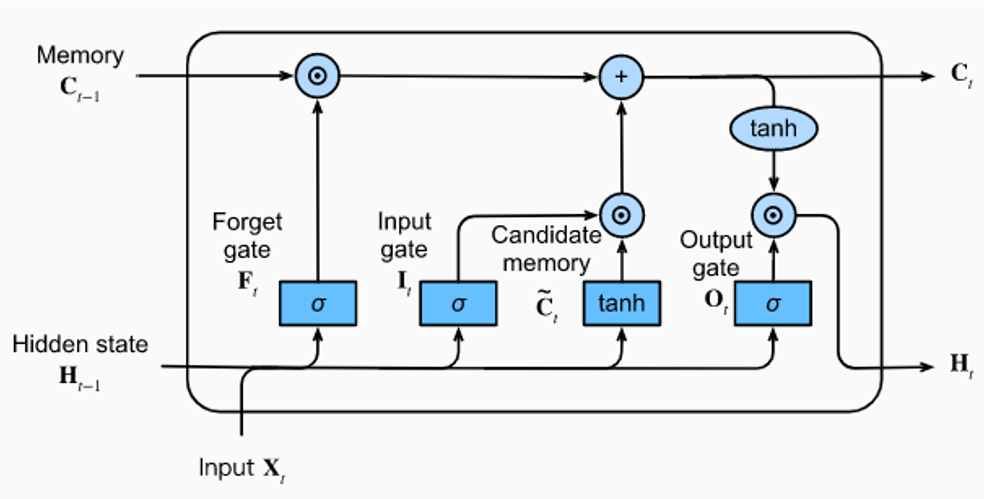


An LSTM cell can learn to recognize an important input (input gate), store it in the long-term state, preserve it for as long as it is needed (forget gate), and extract it whenever it is needed (output gate).

For NLP the architecture of an LSTM model remains fairly the same except the first layer is an embedding layer, which will convert word IDs into embeddings.

In [ ]:
# custom model
def build_model(n_hidden=1, n_neurons=32, learning_rate=0.001, vocab_size=10000, emb_dim=32):
  model = keras.models.Sequential()
  model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=75 ))
  for layer in range(n_hidden):
    # loop to add return_sequences=True is more than 1 hidden layer and is not the last hidden layer
    if n_hidden == 1:
      model.add(keras.layers.LSTM(n_neurons))
    elif layer != (n_hidden - 1):
      model.add(keras.layers.LSTM(n_neurons, return_sequences=True))
    else:
      model.add(keras.layers.LSTM(n_neurons))
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  optimizer = keras.optimizers.Adam(learning_rate)
  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.Precision()])
  return model

In [ ]:
model1 = build_model(1, 64)

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 75, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

In [ ]:
History1 = model1.fit(X_train_padded, y_train, epochs=30,
              validation_data=(X_test_padded, y_test),
              callbacks=[early_stopping_cb])

Epoch 1/30
179/179 [==============================] - 16s 72ms/step - loss: 0.5706 - accuracy: 0.7031 - precision: 0.8094 - val_loss: 0.4420 - val_accuracy: 0.7994 - val_precision: 0.8351
Epoch 2/30
179/179 [==============================] - 15s 85ms/step - loss: 0.3282 - accuracy: 0.8650 - precision: 0.8822 - val_loss: 0.4685 - val_accuracy: 0.7820 - val_precision: 0.7421
Epoch 3/30
179/179 [==============================] - 12s 68ms/step - loss: 0.2136 - accuracy: 0.9180 - precision: 0.9292 - val_loss: 0.5337 - val_accuracy: 0.7721 - val_precision: 0.7319
Epoch 4/30
179/179 [==============================] - 24s 132ms/step - loss: 0.1466 - accuracy: 0.9443 - precision: 0.9484 - val_loss: 0.6486 - val_accuracy: 0.7595 - val_precision: 0.7116
Epoch 5/30
179/179 [==============================] - 20s 115ms/step - loss: 0.1067 - accuracy: 0.9632 - precision: 0.9679 - val_loss: 0.7622 - val_accuracy: 0.7542 - val_precision: 0.7046
Epoch 6/30
179/179 [==============================] - 12s 

In [ ]:
# model evaluation
model1.evaluate(X_test_padded, y_test)

60/60 [==============================] - 1s 17ms/step - loss: 0.4420 - accuracy: 0.7994 - precision: 0.8351


[0.44204407930374146, 0.799369752407074, 0.8351477384567261]

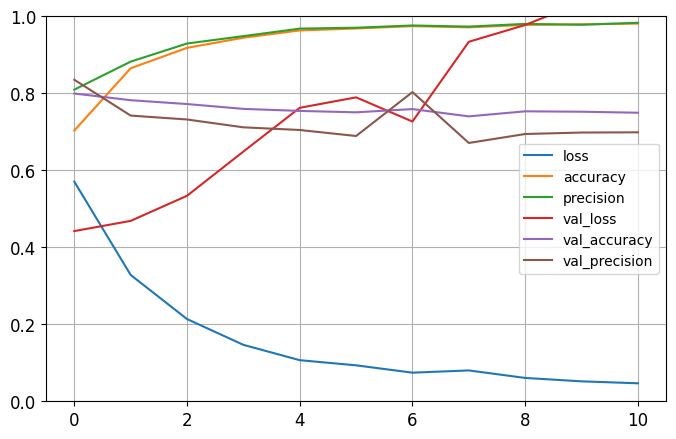

In [ ]:
# display learning curves
pd.DataFrame(History1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

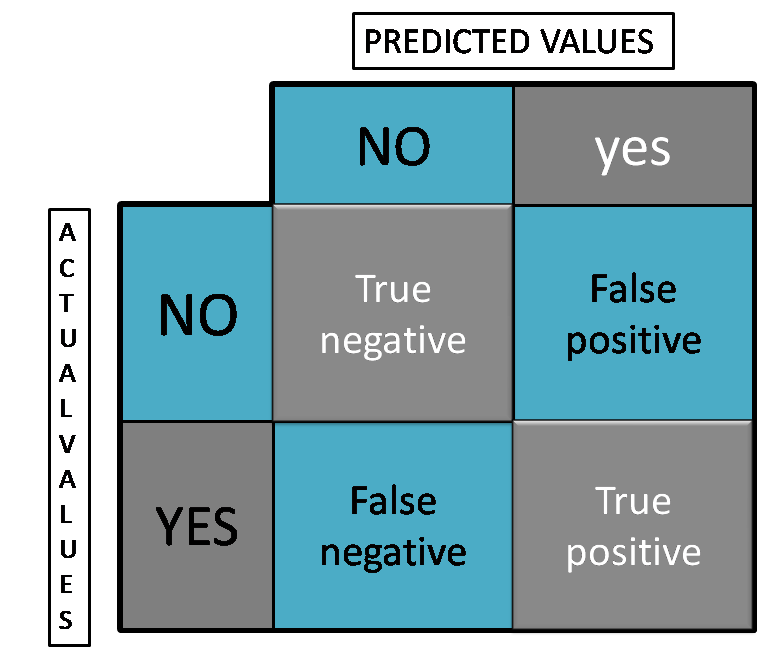

**Understanding Confusion Matrix Terminology**
- True Positive(TP): is an outcome where the model correctly predicts the positive class

- True Negative(TN): is an outcome where the model correctly predicts the negative class.

- False Positive(FP): is an outcome where the model incorrectly predicts the positive class.

- False Negative(FN): is an outcome where the model incorrectly predicts the negative class.

- True Positive Rate(TPR): the ratio of correctly classified positives to the total number of positive instances in the data. TPR = tp / (tp + fn)

- True Negative Rate(TNR): the ratio of correctly classified negatives to the total number of negative instances in the data. TNR = tn / (tn + fp)

- False Positive Rate(FPR): the ratio of negatives in the data which are incorrectly classified as positives to the total number of negative instances in the data. FPR = fp / (fp + tn)

- False Negative Rate(FNR):  the ratio of positive instances in the data which are incorrectly classified as negatives to the total number of positive instances in the data. FNR = fn / (fn + tp)

- You want to see the data consist mostly of true positive and true negatives.

- The aim is to have a high TPR & TNR and a low FPR & FNR

60/60 [==============================] - 1s 17ms/step
Binary Classifcation Metrics
----------------------------
Accuracy: 79.94%
Precision: 83.51%
Misclassification Rate: 20.06%
True Positive Rate(Disaster Tweet Label Accuracy): 66.05%
True Negative Rate(Non-Disaster Tweet Label Accuracy): 90.28%
False Positive Rate: 9.72%
False Negative Rate: 33.95%


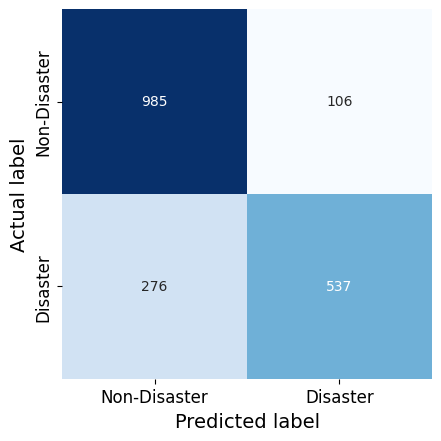

In [ ]:
showConfusionMatrix(model1, X_test_padded, y_test)

####**Model 1 Conclusion:**
- At the end of training: Accuracy=98.11%, Val_Accuracy = 74.95%
- Test Set: Accuracy=79.94%
- The validation loss skyrocketed early into training. The model is overfitting, resulting in worse val and test accuracy even though training accuracy is good.
- When examining the confusion matrix metrics we can see that the models overall does well in detecting non-disaster tweets. TNR=90.28%.
- In the confusion matrix we can also see that the model does not do as well when making predictions on tweets that are actuallty disaster tweets. TPR=66.05%, meaning the model mislabels these tweets as non-disaster 33.95%(FNR)

###**Models 2-5: LSTM - Parameter tuning and additional layers**

Here I am just going to tinker with a bunch of models and see what works. Model 2 will be to evaulate the difference of a hidden layer, model 3 will be the same architecture with a different learning rate.

In [ ]:
# build models
model2 = build_model(2, 64)
model3 = build_model(2, 64, learning_rate=0.0001)

In [ ]:
model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 75, 32)            320000    
                                                                 
 lstm_33 (LSTM)              (None, 75, 64)            24832     
                                                                 
 lstm_34 (LSTM)              (None, 64)                33024     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 377,921
Trainable params: 377,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 75, 32)            320000    
                                                                 
 lstm_35 (LSTM)              (None, 75, 64)            24832     
                                                                 
 lstm_36 (LSTM)              (None, 64)                33024     
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 377,921
Trainable params: 377,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = model2.fit(X_train_padded, y_train, epochs=30,
              validation_data=(X_test_padded, y_test),
              callbacks=[early_stopping_cb])

Epoch 1/30
179/179 [==============================] - 29s 137ms/step - loss: 0.5674 - accuracy: 0.7036 - precision_17: 0.8069 - val_loss: 0.4457 - val_accuracy: 0.7936 - val_precision_17: 0.8387
Epoch 2/30
179/179 [==============================] - 23s 131ms/step - loss: 0.3268 - accuracy: 0.8651 - precision_17: 0.8812 - val_loss: 0.4770 - val_accuracy: 0.7757 - val_precision_17: 0.7271
Epoch 3/30
179/179 [==============================] - 23s 128ms/step - loss: 0.2158 - accuracy: 0.9164 - precision_17: 0.9220 - val_loss: 0.5287 - val_accuracy: 0.7784 - val_precision_17: 0.7435
Epoch 4/30
179/179 [==============================] - 22s 121ms/step - loss: 0.1533 - accuracy: 0.9438 - precision_17: 0.9458 - val_loss: 0.6651 - val_accuracy: 0.7605 - val_precision_17: 0.7022
Epoch 5/30
179/179 [==============================] - 23s 131ms/step - loss: 0.1166 - accuracy: 0.9581 - precision_17: 0.9609 - val_loss: 0.7370 - val_accuracy: 0.7642 - val_precision_17: 0.7209
Epoch 6/30
179/179 [=====

In [ ]:
# model evaluation
model2.evaluate(X_test_padded, y_test)

60/60 [==============================] - 2s 36ms/step - loss: 0.4457 - accuracy: 0.7936 - precision_17: 0.8387


[0.44573211669921875, 0.7935924530029297, 0.8387096524238586]

This model recieved an almost identical accuracy as model 1. The addition of another hidden layer did not strengthen the model.

In [ ]:
# train model 3
history3 = model3.fit(X_train_padded, y_train, epochs=30,
              validation_data=(X_test_padded, y_test),
              callbacks=[early_stopping_cb])

Epoch 1/30
179/179 [==============================] - 29s 137ms/step - loss: 0.6841 - accuracy: 0.5658 - precision_18: 0.3704 - val_loss: 0.6763 - val_accuracy: 0.5730 - val_precision_18: 0.0000e+00
Epoch 2/30
179/179 [==============================] - 23s 129ms/step - loss: 0.6691 - accuracy: 0.5766 - precision_18: 0.9767 - val_loss: 0.6470 - val_accuracy: 0.6166 - val_precision_18: 0.9663
Epoch 3/30
179/179 [==============================] - 21s 120ms/step - loss: 0.5625 - accuracy: 0.7322 - precision_18: 0.7909 - val_loss: 0.4836 - val_accuracy: 0.7820 - val_precision_18: 0.8273
Epoch 4/30
179/179 [==============================] - 24s 132ms/step - loss: 0.3909 - accuracy: 0.8359 - precision_18: 0.8575 - val_loss: 0.4575 - val_accuracy: 0.8036 - val_precision_18: 0.8204
Epoch 5/30
179/179 [==============================] - 25s 141ms/step - loss: 0.3183 - accuracy: 0.8720 - precision_18: 0.8927 - val_loss: 0.4599 - val_accuracy: 0.7978 - val_precision_18: 0.8066
Epoch 6/30
179/179 [=

In [ ]:
# model evaluation
model3.evaluate(X_test_padded, y_test)

60/60 [==============================] - 2s 34ms/step - loss: 0.4575 - accuracy: 0.8036 - precision_18: 0.8204


[0.45753443241119385, 0.8035714030265808, 0.8204379677772522]

#### Models 2-3 Conclusions:
- The addition of a hidden layer did not strengthen the model.
- The change in learning rate (from 0.001 to 0.0001) helped the model perform slightly better. The validation loss for model 3 was half of what the model loss for model 2 was through 11 epochs of training.

In models 4 and 5 I used on lstm layer as model 2 showed the addition of another layer doesn't gain much improvement. I decided to try more and less neurons in the lstm layer to see how the models would change. I also tried a learning rate that had worked well for me in a previous binary classification task.

In [ ]:
model4 = build_model(1, 32, learning_rate=0.0003)
model5 = build_model(1, 128, learning_rate=0.0003)

In [ ]:
# train model 4
history4 = model4.fit(X_train_padded, y_train, epochs=30,
              validation_data=(X_test_padded, y_test),
              callbacks=[early_stopping_cb])

Epoch 1/30
179/179 [==============================] - 13s 49ms/step - loss: 0.6719 - accuracy: 0.5707 - precision_23: 0.5255 - val_loss: 0.6356 - val_accuracy: 0.6292 - val_precision_23: 0.9820
Epoch 2/30
179/179 [==============================] - 10s 53ms/step - loss: 0.5233 - accuracy: 0.7623 - precision_23: 0.8638 - val_loss: 0.4646 - val_accuracy: 0.7962 - val_precision_23: 0.8031
Epoch 3/30
179/179 [==============================] - 9s 53ms/step - loss: 0.3563 - accuracy: 0.8576 - precision_23: 0.8863 - val_loss: 0.4438 - val_accuracy: 0.8072 - val_precision_23: 0.8106
Epoch 4/30
179/179 [==============================] - 9s 50ms/step - loss: 0.2703 - accuracy: 0.8954 - precision_23: 0.9069 - val_loss: 0.4555 - val_accuracy: 0.7983 - val_precision_23: 0.7903
Epoch 5/30
179/179 [==============================] - 9s 53ms/step - loss: 0.2164 - accuracy: 0.9196 - precision_23: 0.9332 - val_loss: 0.4791 - val_accuracy: 0.7931 - val_precision_23: 0.7782
Epoch 6/30
179/179 [=============

In [ ]:
# train model 5
history5 = model5.fit(X_train_padded, y_train, epochs=30,
              validation_data=(X_test_padded, y_test),
              callbacks=[early_stopping_cb])

Epoch 1/30
179/179 [==============================] - 29s 149ms/step - loss: 0.6626 - accuracy: 0.6047 - precision_24: 0.7107 - val_loss: 0.5818 - val_accuracy: 0.7516 - val_precision_24: 0.8386
Epoch 2/30
179/179 [==============================] - 26s 144ms/step - loss: 0.4543 - accuracy: 0.8068 - precision_24: 0.8498 - val_loss: 0.4382 - val_accuracy: 0.8046 - val_precision_24: 0.8016
Epoch 3/30
179/179 [==============================] - 26s 144ms/step - loss: 0.3306 - accuracy: 0.8690 - precision_24: 0.9029 - val_loss: 0.4319 - val_accuracy: 0.8093 - val_precision_24: 0.8178
Epoch 4/30
179/179 [==============================] - 26s 143ms/step - loss: 0.2521 - accuracy: 0.8989 - precision_24: 0.9163 - val_loss: 0.4694 - val_accuracy: 0.7941 - val_precision_24: 0.7545
Epoch 5/30
179/179 [==============================] - 26s 144ms/step - loss: 0.1935 - accuracy: 0.9268 - precision_24: 0.9412 - val_loss: 0.5183 - val_accuracy: 0.7799 - val_precision_24: 0.7391
Epoch 6/30
179/179 [=====

In [ ]:
# model evaluation
model4.evaluate(X_test_padded, y_test)

60/60 [==============================] - 1s 15ms/step - loss: 0.4438 - accuracy: 0.8072 - precision_23: 0.8106


[0.443827360868454, 0.8072478771209717, 0.8105849623680115]

In [ ]:
# model evaluation
model5.evaluate(X_test_padded, y_test)

60/60 [==============================] - 4s 65ms/step - loss: 0.4319 - accuracy: 0.8093 - precision_24: 0.8178


[0.43193361163139343, 0.8093487620353699, 0.8177965879440308]

60/60 [==============================] - 7s 77ms/step
Binary Classifcation Metrics
----------------------------
Accuracy: 80.93%
Precision: 81.78%
Misclassification Rate: 19.07%
True Positive Rate(Disaster Tweet Label Accuracy): 71.22%
True Negative Rate(Non-Disaster Tweet Label Accuracy): 88.18%
False Positive Rate: 11.82%
False Negative Rate: 28.78%


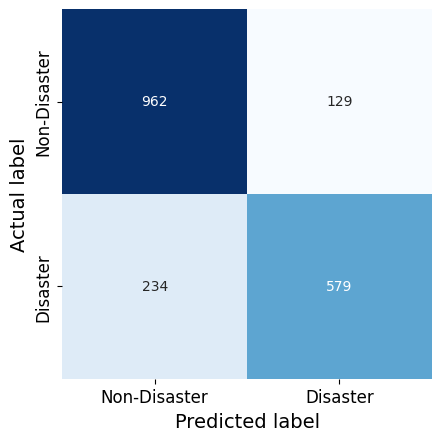

In [ ]:
showConfusionMatrix(model5, X_test_padded, y_test)

####**Models 4-5 Conclusions:**
- Model 4 with 32 neurons was average to say the least.
- Model 5 with 128 neurons had the best test accuracy of 80.93%, a 1% increase from where we started. Model 5 had a better TPR than model 1, but a lower TNR.


In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

###**Hyperparameter Tuning**

In [ ]:
keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)

<ipython-input-125-da04424654c8>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)


In [ ]:
param_distribs = {
   "n_neurons": np.arange(64, 256),
   "learning_rate": reciprocal(3e-4, 3e-2),
   "emb_dim": [32, 64, 128]
}

In [ ]:
rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=3)
cv_hist = rnd_search_cv.fit(X_train_padded, y_train, epochs=30,
              validation_data=(X_test_padded, y_test),
              callbacks=[early_stopping_cb])

Epoch 1/30
119/119 [==============================] - 17s 121ms/step - loss: 0.5459 - accuracy: 0.7315 - precision_33: 0.7494 - val_loss: 0.4853 - val_accuracy: 0.7736 - val_precision_33: 0.7624
Epoch 2/30
119/119 [==============================] - 13s 113ms/step - loss: 0.2815 - accuracy: 0.8836 - precision_33: 0.8860 - val_loss: 0.5947 - val_accuracy: 0.7579 - val_precision_33: 0.7573
Epoch 3/30
119/119 [==============================] - 13s 113ms/step - loss: 0.1518 - accuracy: 0.9422 - precision_33: 0.9457 - val_loss: 0.8451 - val_accuracy: 0.7532 - val_precision_33: 0.7174
Epoch 4/30
119/119 [==============================] - 13s 113ms/step - loss: 0.0878 - accuracy: 0.9611 - precision_33: 0.9596 - val_loss: 0.9290 - val_accuracy: 0.7395 - val_precision_33: 0.6863
Epoch 5/30
119/119 [==============================] - 14s 114ms/step - loss: 0.0568 - accuracy: 0.9745 - precision_33: 0.9772 - val_loss: 1.0961 - val_accuracy: 0.7484 - val_precision_33: 0.7032
Epoch 6/30
119/119 [=====

In [ ]:
#rnd_search_cv.best_params_
# best parameters were emb_dim=128, n_nuerons=65, learning_rate=0.0003xxx

###**Model 6: Adding Dense layer and Dropout**

In [ ]:
model6 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=75),
    keras.layers.LSTM(64, dropout=0.2),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
optimizer = keras.optimizers.Adam(0.0003)
model6.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.Precision()])

In [ ]:
history6 = model6.fit(X_train_padded, y_train, epochs=30,
              validation_data=(X_test_padded, y_test),
              callbacks=[early_stopping_cb])

Epoch 1/30
179/179 [==============================] - 23s 100ms/step - loss: 0.6626 - accuracy: 0.5817 - precision_1: 0.8571 - val_loss: 0.6175 - val_accuracy: 0.6623 - val_precision_1: 0.9775
Epoch 2/30
179/179 [==============================] - 16s 92ms/step - loss: 0.4866 - accuracy: 0.7954 - precision_1: 0.8468 - val_loss: 0.4548 - val_accuracy: 0.7952 - val_precision_1: 0.7765
Epoch 3/30
179/179 [==============================] - 18s 99ms/step - loss: 0.3028 - accuracy: 0.8846 - precision_1: 0.8926 - val_loss: 0.4607 - val_accuracy: 0.7988 - val_precision_1: 0.8011
Epoch 4/30
179/179 [==============================] - 18s 99ms/step - loss: 0.2209 - accuracy: 0.9205 - precision_1: 0.9249 - val_loss: 0.5307 - val_accuracy: 0.7889 - val_precision_1: 0.7473
Epoch 5/30
179/179 [==============================] - 17s 93ms/step - loss: 0.1639 - accuracy: 0.9427 - precision_1: 0.9453 - val_loss: 0.5699 - val_accuracy: 0.7763 - val_precision_1: 0.7583
Epoch 6/30
179/179 [===================

In [ ]:
# model evaluation
model6.evaluate(X_test_padded, y_test)

60/60 [==============================] - 1s 17ms/step - loss: 0.4548 - accuracy: 0.7952 - precision_1: 0.7765


[0.4548249840736389, 0.7951680421829224, 0.7764706015586853]

####Model 6 Conclusion
- The hyperparameters from randomized search cross validation were almost identical to parameters I had used prior, so this did not effect the model much.

- The addition of another dense layer and dropout did not solve the overfitting problem

###**Models 7-9: GRU, BidirectionGRU, and BidirectionalLSTM**

For model 7 I decided to use a GRU cell, which is a simplified version of the LSTM cell with both state vectors merged, a single gate for both the forget and input gate, and no output gate.

In [ ]:
model7 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=75),
    keras.layers.GRU(64),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 75, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,318,305
Trainable params: 1,318,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.Adam(0.0003)
model7.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.Precision()])

history7 = model7.fit(X_train_padded, y_train, epochs=30,
              validation_data=(X_test_padded, y_test),
              callbacks=[early_stopping_cb])

Epoch 1/30
179/179 [==============================] - 20s 93ms/step - loss: 0.6454 - accuracy: 0.6274 - precision_4: 0.8177 - val_loss: 0.5563 - val_accuracy: 0.7710 - val_precision_4: 0.8577
Epoch 2/30
179/179 [==============================] - 16s 87ms/step - loss: 0.3946 - accuracy: 0.8397 - precision_4: 0.8483 - val_loss: 0.4777 - val_accuracy: 0.7789 - val_precision_4: 0.7258
Epoch 3/30
179/179 [==============================] - 17s 94ms/step - loss: 0.2406 - accuracy: 0.9073 - precision_4: 0.9092 - val_loss: 0.5305 - val_accuracy: 0.7904 - val_precision_4: 0.7875
Epoch 4/30
179/179 [==============================] - 16s 88ms/step - loss: 0.1656 - accuracy: 0.9380 - precision_4: 0.9365 - val_loss: 0.6168 - val_accuracy: 0.7610 - val_precision_4: 0.7077
Epoch 5/30
179/179 [==============================] - 16s 91ms/step - loss: 0.1169 - accuracy: 0.9585 - precision_4: 0.9579 - val_loss: 0.7136 - val_accuracy: 0.7616 - val_precision_4: 0.7114
Epoch 6/30
179/179 [====================

In [ ]:
# model evaluation
model7.evaluate(X_test_padded, y_test)

60/60 [==============================] - 1s 15ms/step - loss: 0.4777 - accuracy: 0.7789 - precision_4: 0.7258


[0.4776949882507324, 0.7788865566253662, 0.725806474685669]

**BidirectionalLSTM and BidirectionalGRU**

A Bidirectional layer may be helpful for this NLP task. A bidirectional layer runs two recurrent layers on the same inputs, one reading beginning to end, and the other from end to beginning.

In [ ]:
model8 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=75),
    keras.layers.Bidirectional(keras.layers.GRU(64)),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model8.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 75, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              74496     
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 16)                2064      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,356,577
Trainable params: 1,356,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.Adam(0.0003)
model8.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.Precision()])

history8 = model8.fit(X_train_padded, y_train, epochs=30,
              validation_data=(X_test_padded, y_test),
              callbacks=[early_stopping_cb])

Epoch 1/30
179/179 [==============================] - 31s 143ms/step - loss: 0.6423 - accuracy: 0.6239 - precision_5: 0.7940 - val_loss: 0.5108 - val_accuracy: 0.7862 - val_precision_5: 0.8152
Epoch 2/30
179/179 [==============================] - 24s 136ms/step - loss: 0.3742 - accuracy: 0.8466 - precision_5: 0.8547 - val_loss: 0.4878 - val_accuracy: 0.7736 - val_precision_5: 0.7180
Epoch 3/30
179/179 [==============================] - 24s 132ms/step - loss: 0.2390 - accuracy: 0.9047 - precision_5: 0.9121 - val_loss: 0.5364 - val_accuracy: 0.7794 - val_precision_5: 0.7555
Epoch 4/30
179/179 [==============================] - 24s 135ms/step - loss: 0.1662 - accuracy: 0.9350 - precision_5: 0.9364 - val_loss: 0.6318 - val_accuracy: 0.7558 - val_precision_5: 0.6916
Epoch 5/30
179/179 [==============================] - 25s 138ms/step - loss: 0.1179 - accuracy: 0.9545 - precision_5: 0.9538 - val_loss: 0.7321 - val_accuracy: 0.7568 - val_precision_5: 0.7016
Epoch 6/30
179/179 [===============

In [ ]:
# model evaluation
model8.evaluate(X_test_padded, y_test)

60/60 [==============================] - 2s 38ms/step - loss: 0.4878 - accuracy: 0.7736 - precision_5: 0.7180


[0.48778611421585083, 0.7736344337463379, 0.7180365324020386]

In [ ]:
model9 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=75),
    keras.layers.Bidirectional(keras.layers.LSTM(128)),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
optimizer = keras.optimizers.Adam(0.0003)
model9.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.Precision()])

history9 = model9.fit(X_train_padded, y_train, epochs=30,
              validation_data=(X_test_padded, y_test),
              callbacks=[early_stopping_cb])

Epoch 1/30
179/179 [==============================] - 51s 262ms/step - loss: 0.6598 - accuracy: 0.6068 - precision_6: 0.7169 - val_loss: 0.5525 - val_accuracy: 0.7736 - val_precision_6: 0.8271
Epoch 2/30
179/179 [==============================] - 48s 269ms/step - loss: 0.4028 - accuracy: 0.8287 - precision_6: 0.8531 - val_loss: 0.4511 - val_accuracy: 0.7920 - val_precision_6: 0.7577
Epoch 3/30
179/179 [==============================] - 49s 275ms/step - loss: 0.2736 - accuracy: 0.8914 - precision_6: 0.9099 - val_loss: 0.4717 - val_accuracy: 0.8004 - val_precision_6: 0.7868
Epoch 4/30
179/179 [==============================] - 47s 260ms/step - loss: 0.2001 - accuracy: 0.9254 - precision_6: 0.9387 - val_loss: 0.5260 - val_accuracy: 0.7925 - val_precision_6: 0.7779
Epoch 5/30
179/179 [==============================] - 46s 259ms/step - loss: 0.1511 - accuracy: 0.9418 - precision_6: 0.9504 - val_loss: 0.6173 - val_accuracy: 0.7700 - val_precision_6: 0.7262
Epoch 6/30
179/179 [===============

In [ ]:
# model evaluation
model9.evaluate(X_test_padded, y_test)

60/60 [==============================] - 5s 92ms/step - loss: 0.4511 - accuracy: 0.7920 - precision_6: 0.7577


[0.45106929540634155, 0.7920168042182922, 0.7577255964279175]

####**Models 7-9 Conclusions**
- The GRU models performed slightly worse than the LSTM models by around 1 percent of the test data.
- Bidirectional rnn layers did not improve the model. The model is still overfitting.

###**Model 10: Reusing Pretrained Embedding from TF Hub**

In [ ]:
import tensorflow_hub as hub

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", output_shape=[50],
                           input_shape=[], dtype=tf.string)

model10 = keras.Sequential()
model10.add(hub_layer)
model10.add(keras.layers.Dense(16, activation='relu'))
model10.add(keras.layers.Dense(1, activation='sigmoid'))

model10.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_14 (Dense)            (None, 16)                816       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [ ]:
model10.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", tf.keras.metrics.Precision()])

history10 = model10.fit(X_train, y_train, epochs=100,
              validation_data=(X_test, y_test),
              callbacks=[early_stopping_cb])

Epoch 1/100
179/179 [==============================] - 2s 5ms/step - loss: 0.6464 - accuracy: 0.6402 - precision_10: 0.5703 - val_loss: 0.5751 - val_accuracy: 0.7421 - val_precision_10: 0.7170
Epoch 2/100
179/179 [==============================] - 1s 3ms/step - loss: 0.5348 - accuracy: 0.7528 - precision_10: 0.7338 - val_loss: 0.5117 - val_accuracy: 0.7647 - val_precision_10: 0.7186
Epoch 3/100
179/179 [==============================] - 1s 5ms/step - loss: 0.5045 - accuracy: 0.7649 - precision_10: 0.7489 - val_loss: 0.4948 - val_accuracy: 0.7731 - val_precision_10: 0.7402
Epoch 4/100
179/179 [==============================] - 1s 4ms/step - loss: 0.4939 - accuracy: 0.7728 - precision_10: 0.7623 - val_loss: 0.4871 - val_accuracy: 0.7768 - val_precision_10: 0.7487
Epoch 5/100
179/179 [==============================] - 1s 5ms/step - loss: 0.4887 - accuracy: 0.7726 - precision_10: 0.7653 - val_loss: 0.4842 - val_accuracy: 0.7805 - val_precision_10: 0.7491
Epoch 6/100
179/179 [==============

In [ ]:
# model evaluation
model10.evaluate(X_test, y_test)

60/60 [==============================] - 0s 2ms/step - loss: 0.4735 - accuracy: 0.7810 - precision_10: 0.7633


[0.47346213459968567, 0.7809873819351196, 0.7632978558540344]

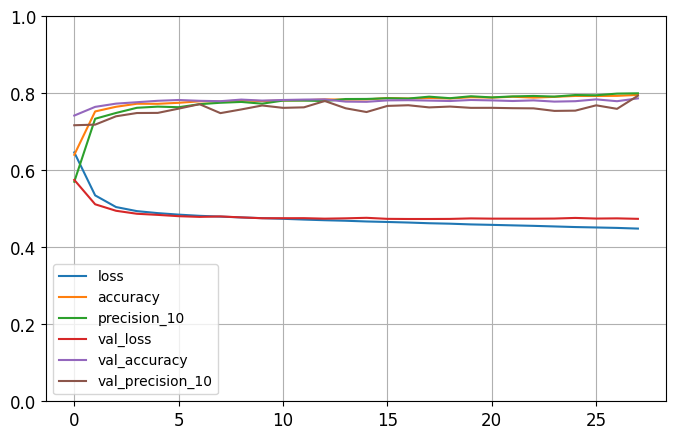

In [ ]:
# display learning curves
pd.DataFrame(history10.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

60/60 [==============================] - 1s 4ms/step
Binary Classifcation Metrics
----------------------------
Accuracy: 78.10%
Precision: 76.33%
Misclassification Rate: 21.90%
True Positive Rate(Disaster Tweet Label Accuracy): 70.60%
True Negative Rate(Non-Disaster Tweet Label Accuracy): 83.68%
False Positive Rate: 16.32%
False Negative Rate: 29.40%


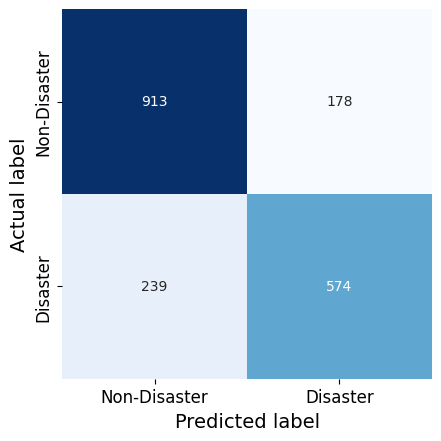

In [ ]:
showConfusionMatrix(model10, X_test, y_test)

###**Final Results/Conclusions**

- The best performing model was model 5 with a training accuracy of 80.93%. In this model I used a single LSTM layer, with 128 neurons, and a learning rate of 0.0001

- Validation loss had a tendency to skyrocket after a few epochs in most models. Adjusting learning rates seem to keep it down to 0.4-0.5 through 10 epochs before steadily rising.

- Unstable gradients and overfitting were a constant issue. Models could reach above 98% training accuracy but were not effective at handling new instances. I tried deep networks, adding dropout, adding reccurent dropout, stacked dense layers, and many different parameters, but the models stayed in the range of 78-80% test accuracy. Even hyperparameter tuning did not yield better results than my best model.

Potential Improvements:
- The next thing I want to work on is more preprocessing as that may likely be the culprit. Cleaning out repeating characters, usernames, and strange uncommon words are the tasks I will try next.

- Applying more transfer learning and pretrained embeddings layer models, such as BERT and GloVe

- Test out more layer normalization techniques.
